In [2]:
%matplotlib notebook
#%matplotlib inline
from IPython.display import HTML
from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
from time import sleep
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.geometry import SceneGraph
from pydrake.systems.planar_scenegraph_visualizer import (
    ConnectPlanarSceneGraphVisualizer)
from pydrake.examples.acrobot import (AcrobotParams, AcrobotPlant, 
                                      AcrobotGeometry, AcrobotSpongController, 
                                      AcrobotState, AcrobotInput)
from pydrake.all import (LinearQuadraticRegulator, Saturation, WrapToSystem, 
                         VectorSystem, FittedValueIteration, LinearSystem,
                         DynamicProgrammingOptions)
from pydrake.systems.primitives import (Linearize)

INFO:drake:Computing transition and cost matrices.
INFO:drake:Done computing transition and cost matrices.
INFO:drake:Running value iteration.
INFO:drake:Value iteration converged to requested tolerance.


<IPython.core.display.Javascript object>


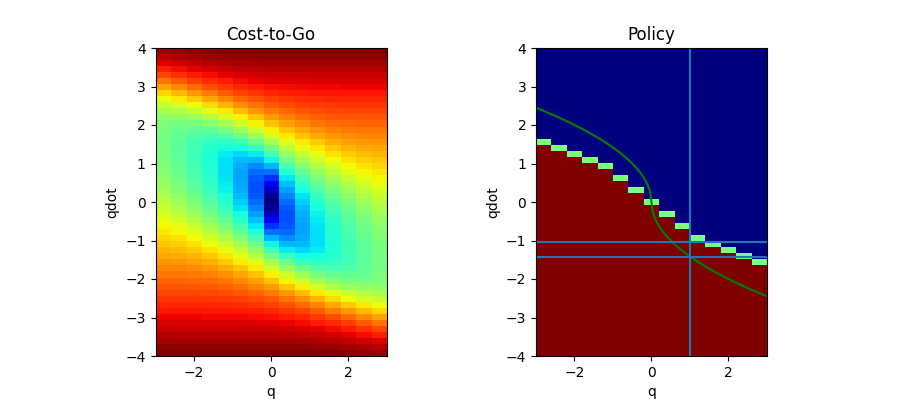

None

In [5]:
def DoubleIntegrator():
    return LinearSystem(A=np.mat('0 1; 0 0'),
                        B=np.mat('0; 1'),
                        C=np.eye(2),
                        D=np.zeros((2,1)))
    
plant = DoubleIntegrator()

def double_integrator_example(cost_function,
                              convergence_tol,
                              animate=True,
                              plot=True,
                              draw_iterations=True):
    simulator = Simulator(plant)
    options = DynamicProgrammingOptions()

    qbins = np.linspace(-3., 3., 15)
    qdotbins = np.linspace(-4., 4., 51)
    state_grid = [set(qbins), set(qdotbins)]

    input_limit = 1.
    input_grid = [set(np.linspace(-input_limit, input_limit, 9))]
    timestep = 0.01

    [Q, Qdot] = np.meshgrid(qbins, qdotbins)

    def simulate(policy):
        # Animate the resulting policy.
        builder = DiagramBuilder()
        plant = builder.AddSystem(DoubleIntegrator())

        vi_policy = builder.AddSystem(policy)
        builder.Connect(plant.get_output_port(0), vi_policy.get_input_port(0))
        builder.Connect(vi_policy.get_output_port(0), plant.get_input_port(0))

        diagram = builder.Build()
        simulator = Simulator(diagram)

        simulator.get_mutable_context().SetContinuousState([-10.0, 0.0])
        simulator.AdvanceTo(10.)

    options.convergence_tol = convergence_tol

    policy, cost_to_go = FittedValueIteration(simulator, cost_function,
                                              state_grid, input_grid, timestep,
                                              options)

    J = np.reshape(cost_to_go, Q.shape)

    if plot:
        fig = plt.figure(1, figsize=(9, 4))
        ax1, ax2 = fig.subplots(1, 2)
        ax1.set_xlabel("q")
        ax1.set_ylabel("qdot")
        ax1.set_title("Cost-to-Go")
        ax2.set_xlabel("q")
        ax2.set_ylabel("qdot")
        ax2.set_title("Policy")
        ax1.imshow(J,
                   cmap=cm.jet,
                   extent=(qbins[0], qbins[-1], qdotbins[-1], qdotbins[0]))
        ax1.invert_yaxis()
        Pi = np.reshape(policy.get_output_values(), Q.shape)
        ax2.imshow(Pi,
                   cmap=cm.jet,
                   extent=(qbins[0], qbins[-1], qdotbins[-1], qdotbins[0]))
        ax2.invert_yaxis()
        q = np.linspace(-3., 3., 100)
        qdot = -1*np.sign(q)*np.sqrt(2*np.abs(q))

        ax2.plot(q, qdot, 'g')
        ax2.axvline(x=1.0)
        ax2.axhline(y=-1.05)
        ax2.axhline(y=-1.43)
        display(plt.show())

def min_time_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    if x.dot(x) < .05:
        return 0.
    return 1.


double_integrator_example(cost_function=min_time_cost,
                          convergence_tol=0.001,
                          animate=True);

In [7]:
def setup_acrobot(acrobot_params: AcrobotParams, show: bool=True):
    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())
    acrobot.set_name("acrobot")
    scene_graph = builder.AddSystem(SceneGraph())
    AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)

    T_VW = np.array([[1., 0., 0., 0.],
                     [0., 0., 1., 0.],
                     [0., 0., 0., 1.]])
    visualizer = ConnectPlanarSceneGraphVisualizer(
        builder, scene_graph, T_VW=T_VW, xlim=[-2, 2],
        ylim=[-2, 2], show=show)
    
    return acrobot, builder, visualizer

def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state

<IPython.core.display.Javascript object>


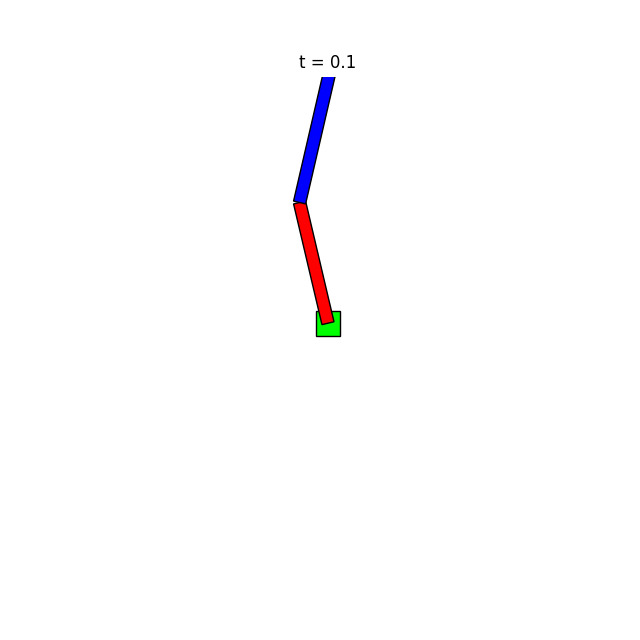

In [8]:
def BalancingLQR():
    # Tune the LQR controller to stabilize the Acrobot around the upright.
    # Returns a (static) AffineSystem that implements the controller (in
    # the original AcrobotState coordinates).

    acrobot = AcrobotPlant()
    context = acrobot.CreateDefaultContext()

    input = AcrobotInput()
    input.set_tau(0.)
    acrobot.get_input_port(0).FixValue(context, input)

    context.get_mutable_continuous_state_vector()\
        .SetFromVector(UprightState().CopyToVector())

    # The parameters to tune.
    Q = np.diag((7., 2., 3., 6.))
    R = [1.]

    return LinearQuadraticRegulator(acrobot, context, Q, R)

def run_acrobot_LQR_controller(duration: float=5., playback: bool=True, show: bool=True):
    """
    Simulate the LQR controller.
    """

    acrobot, builder, visualizer = setup_acrobot(AcrobotParams(), show)
    saturation = builder.AddSystem(Saturation(min_value=[-30], max_value=[30]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    controller = builder.AddSystem(BalancingLQR())
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))

    if playback:
        visualizer.start_recording()

    diagram = builder.Build()
    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.)

    acrobot_context = diagram.GetMutableSubsystemContext(
        acrobot, simulator.get_mutable_context())

    # Set initial state.
    x0 = acrobot_context.get_mutable_continuous_state_vector()
    x0[0] = np.pi-0.1 # theta1
    x0[1] = 0.15 # theta2
    x0[2] = 0. # dtheta1
    x0[3] = 0.5 # dtheta2
    state_traj = np.array([x0.CopyToVector()])
    # Simulate and record the state trajectory.
    while simulator.get_context().get_time() < duration:
      simulator.AdvanceTo(simulator.get_context().get_time() + 0.01)
      state = simulator.get_context().get_continuous_state().CopyToVector()
      state_traj = np.append(state_traj, np.array([state]), axis=0)
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('Phase plot for the two joints.')
    ax1.set_xlabel('theta1')
    ax1.set_ylabel('dtheta1')
    ax1.plot(state_traj[:,0],state_traj[:,2])
    ax2.set_xlabel('theta2')
    ax2.set_ylabel('dtheta2')
    ax2.plot(state_traj[:,1],state_traj[:,3])
    plt.show()
    
    if playback:
        visualizer.stop_recording()
        ani = visualizer.get_recording_as_animation()
        return ani
    else:
        return None

ani = run_acrobot_LQR_controller(duration=10., playback=True)

HTML(ani.to_jshtml())

if animation.writers.is_available("ffmpeg"):
    display(HTML(ani.to_html5_video()))
